# Podoli Webcam Data Processing

In [103]:
import cv2
import requests
import ffmpeg
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from datetime import datetime, timezone, timedelta
import os

## get stream url and video

In [196]:
# Function to  create webcam url
def create_webcam_url(specific_time_str):
    # Base URL and static parameters
    base_url = 'https://www.holidayinfo.cz/hol3_data.php'
    params = {
        'type': 'camvideo',
        'ext': 'mp4',
        'camid': '2131'
    } 
    # Add datetime parameter to the params dictionary
    params['cdt'] = specific_time_str
    params['dt'] = specific_time_str
    # Construct the final URL
    stream_url = f"{base_url}?{'&'.join(f'{key}={value}' for key, value in params.items())}"
    return stream_url

In [197]:
# Function to download the video stream
def download_stream(url, output_path):
    try:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(output_path, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
        print(f'Successfully downloaded the stream to {output_path}')
    except requests.exceptions.RequestException as e:
        print(f'Failed to download the stream: {e}')


In [198]:
#Function to download web stream localy
def download_webcam_stream_specific_time(specific_time_str, stream_downld_folder):
    stream_url = create_webcam_url(specific_time_str)
    stream_file_name = 'webcam_stream_{}.mp4'.format(specific_time_str)
    output_file = os.path.join(stream_downld_folder,stream_file_name)
    download_stream(stream_url, output_file)

In [104]:
specific_time = datetime(2024, 7, 2, 5, 0)
specific_time_str = specific_time.strftime('%Y%m%d%H%M%S')
create_webcam_url(specific_time_str)

'https://www.holidayinfo.cz/hol3_data.php?type=camvideo&ext=mp4&camid=2131&cdt=20240702050000&dt=20240702050000'

In [200]:
for hr in range(8,20):
    specific_time = datetime(2024, 7, 9, hr, 0)
    specific_time_str = specific_time.strftime('%Y%m%d%H%M%S')
    stream_downld_folder = r'f:\plovarna\stream_videos'
    download_webcam_stream_specific_time(specific_time_str, stream_downld_folder)

Successfully downloaded the stream to f:\plovarna\stream_videos\webcam_stream_20240709080000.mp4
Successfully downloaded the stream to f:\plovarna\stream_videos\webcam_stream_20240709090000.mp4
Successfully downloaded the stream to f:\plovarna\stream_videos\webcam_stream_20240709100000.mp4
Successfully downloaded the stream to f:\plovarna\stream_videos\webcam_stream_20240709110000.mp4
Successfully downloaded the stream to f:\plovarna\stream_videos\webcam_stream_20240709120000.mp4
Successfully downloaded the stream to f:\plovarna\stream_videos\webcam_stream_20240709130000.mp4
Successfully downloaded the stream to f:\plovarna\stream_videos\webcam_stream_20240709140000.mp4
Successfully downloaded the stream to f:\plovarna\stream_videos\webcam_stream_20240709150000.mp4
Successfully downloaded the stream to f:\plovarna\stream_videos\webcam_stream_20240709160000.mp4
Successfully downloaded the stream to f:\plovarna\stream_videos\webcam_stream_20240709170000.mp4
Successfully downloaded the st

## generate pictures

In [57]:
videos_lst = os.listdir(stream_downld_folder)

In [194]:
def extract_frames(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    # Check if the video was opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
    else:
        # Initialize frame count
        frame_count = 0
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        # Read frames in a loop
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                print("Error: Could not read frame.")
                break
            frame_count += 1
            # Check if the current frame is the target frame
            if frame_count <= total_frames:
                # Convert the frame to RGB (OpenCV uses BGR by default)
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                # Save the frame as an image file
                folder_path = os.path.dirname(video_path)
                video_name = os.path.basename(video_path)
                video_name = video_name.split('.')[0]
                #frame_name = video_name + '_{}.png'.format(frame_count)
                frame_name = f"{video_name}{'_'+str(frame_count).zfill(4)}{'.png'}"
                frame_name = os.path.join(folder_path,frame_name)

                cv2.imwrite(frame_name, frame)
            else:
                break
    
        # Release the video capture object
        cap.release()

In [195]:
extract_frames(r'f:\plovarna\stream_videos\20240701100000\video\webcam_stream_20240701100000.mp4')

Error: Could not read frame.


## extract keyframes

In [81]:
import json
import subprocess

def get_frames_metadata(file):
    command = '"{ffexec}" -show_frames -print_format json "{filename}"'.format(ffexec='ffprobe', filename=file)
    response_json = subprocess.check_output(command, shell=True, stderr=None)
    frames = json.loads(response_json)["frames"]
    frames_metadata, frames_type, frames_type_bool = [], [], []
    for frame in frames:
        if frame["media_type"] == "video":
            video_frame = json.dumps(dict(frame), indent=4)
            frames_metadata.append(video_frame)
            frames_type.append(frame["pict_type"])
            if frame["pict_type"] == "I" and frame["key_frame"]:
                frames_type_bool.append(True)
            else:
                frames_type_bool.append(False)
#     print(frames_type)
    return frames_metadata, frames_type, frames_type_bool

In [85]:
filename =r'f:\plovarna\stream_videos_kf\webcam_stream_20240701190000.mp4'

In [93]:
def extract_keyframes(video_path,keyframes_index):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    # Check if the video was opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
    else:
        # Initialize frame count
        frame_count = 0
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print(total_frames)
        # Read frames in a loop
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                print("Error: Could not read frame.")
                break
            frame_count += 1
            # Check if the current frame is the target frame
            if frame_count in keyframes_index:
                # Convert the frame to RGB (OpenCV uses BGR by default)
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
                # Save the frame as an image file
                folder_path = os.path.dirname(video_path)
                video_name = os.path.basename(video_path)
                video_name = video_name.split('.')[0]
                frame_name = video_name + '_{}.png'.format(frame_count)
                frame_name = os.path.join(folder_path,frame_name)
                cv2.imwrite(frame_name, frame)
            else:
                continue
    
        # Release the video capture object
        cap.release()

In [94]:
_,_, isKeyFrame = get_frames_metadata(filename)
keyframes_index = [i for i,b in enumerate(isKeyFrame) if b]

In [95]:
extract_keyframes(filename,keyframes_index)

975
Error: Could not read frame.


## resize

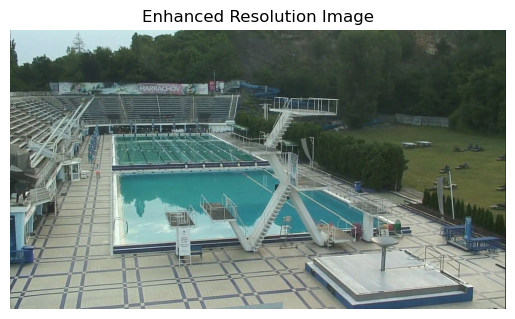

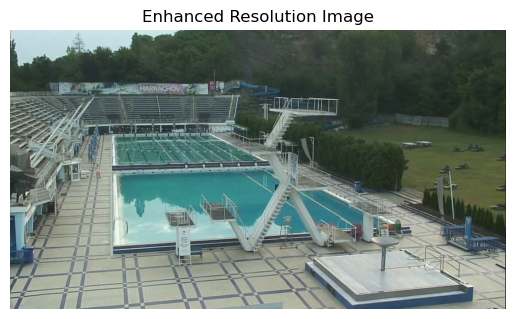

True

In [7]:
#Read the image using imread function
image = cv2.imread('webcam_stream_20240629165237_85.png')
 
 # Display the result
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Enhanced Resolution Image')
plt.axis('off')
plt.show()


# let's upscale the image using new  width and height
up_width = 1280*5
up_height = 720*5
up_points = (up_width, up_height)
resized_up = cv2.resize(image, None, fx=5,fy=5)

 # Display the result
plt.imshow(cv2.cvtColor(resized_up, cv2.COLOR_BGR2RGB))
plt.title('Enhanced Resolution Image')
plt.axis('off')
plt.show()
result_path = 'webcam_stream_20240629165237_85_rs.png'
cv2.imwrite(result_path, resized_up)
result_path = 'webcam_stream_20240629165237_85_org.png'
cv2.imwrite(result_path, image)

## super resolution dnn

In [3]:
from cv2 import dnn_superres

In [4]:
#Read the image using imread function
image = cv2.imread('webcam_stream_20240629165237_85.png')

In [5]:
cv2.__version__

'4.10.0'

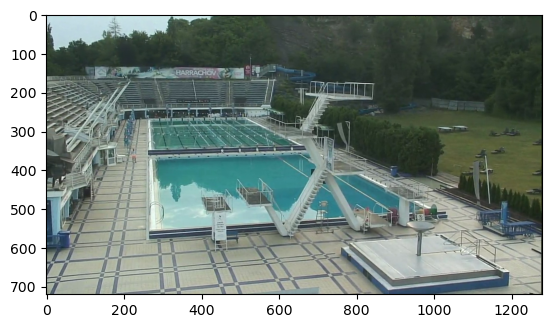

In [6]:
plt.figure()
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [7]:
# Create an SR object
sr = dnn_superres.DnnSuperResImpl_create()

In [8]:
# Read the desired model
path = r"C:\Users\martin\EDSR_x3.pb"
sr.readModel(path)


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\dnn\src\tensorflow\tf_io.cpp:42: error: (-2:Unspecified error) FAILED: ReadProtoFromBinaryFile(param_file, param). Failed to parse GraphDef file: C:\Users\martin\EDSR_x3.pb in function 'cv::dnn::ReadTFNetParamsFromBinaryFileOrDie'


In [ ]:



# Set the desired model and scale to get correct pre- and post-processing
sr.setModel("edsr", 3)

# Upscale the image
result = sr.upsample(image)

# Save the image
cv2.imwrite("./upscaled.png", result)

## align

In [ ]:
F:\plovarna\stream_videos\webcam_stream_20240701130000_681.png

In [105]:
[r'F:\plovarna\stream_videos\webcam_stream_20240701130000_{}.png'.format(i) for i in range(681,685)]

['F:\\plovarna\\stream_videos\\webcam_stream_20240701130000_681.png',
 'F:\\plovarna\\stream_videos\\webcam_stream_20240701130000_682.png',
 'F:\\plovarna\\stream_videos\\webcam_stream_20240701130000_683.png',
 'F:\\plovarna\\stream_videos\\webcam_stream_20240701130000_684.png']

1
2
3
4
5
6
7


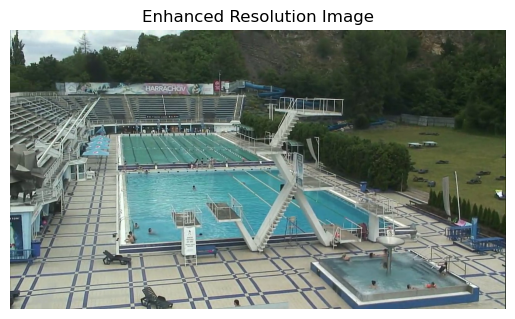

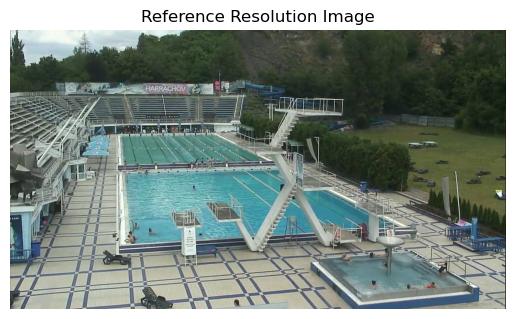

Result saved as enhanced_resolution.png
Result saved as ref_img.png


In [109]:
image_paths = [r'F:\plovarna\stream_videos\webcam_stream_20240701130000_{}.png'.format(i) for i in range(681,688)]



# Load the images
images = [cv2.imread(image_path) for image_path in image_paths]

# Check if images are loaded successfully
for i, img in enumerate(images):
    if img is None:
        print(f"Error: Could not load image {image_paths[i]}")
        exit(1)

# Use the first image as the reference
reference_image = images[0]

# Initialize the aligned images list
aligned_images = []

# Align images to the reference image
for img in images:
    # Use ORB detector to find keypoints and descriptors
    orb = cv2.ORB_create()
    keypoints1, descriptors1 = orb.detectAndCompute(reference_image, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img, None)

    # Match descriptors using BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)

    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)
    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography matrix
    h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

    # Warp image to the reference image
    height, width = reference_image.shape[:2]
    aligned_img = cv2.warpPerspective(img, h, (width, height))

    aligned_images.append(aligned_img)
    print(len(aligned_images))

# Average the aligned images
average_image = np.zeros_like(aligned_images[0], dtype=np.float32)
for img in aligned_images:
    average_image += img.astype(np.float32)

average_image /= len(aligned_images)
average_image = np.clip(average_image, 0, 255).astype(np.uint8)

# Display the result
plt.imshow(cv2.cvtColor(average_image, cv2.COLOR_BGR2RGB))
plt.title('Enhanced Resolution Image')
plt.axis('off')
plt.show()

plt.imshow(cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB))
plt.title('Reference Resolution Image')
plt.axis('off')
plt.show()

# Save the result as a PNG file
result_path = 'enhanced_resolution.png'
cv2.imwrite(result_path, average_image)
print(f"Result saved as {result_path}")

# Save the ref as a PNG file
result_path = 'ref_img.png'
cv2.imwrite(result_path, reference_image)
print(f"Result saved as {result_path}")



In [18]:
%matplotlib inline

['F:\\plovarna\\stream_videos\\webcam_stream_20240701130000_681.png', 'F:\\plovarna\\stream_videos\\webcam_stream_20240701130000_682.png', 'F:\\plovarna\\stream_videos\\webcam_stream_20240701130000_683.png', 'F:\\plovarna\\stream_videos\\webcam_stream_20240701130000_684.png']
4 images aligned successfully.


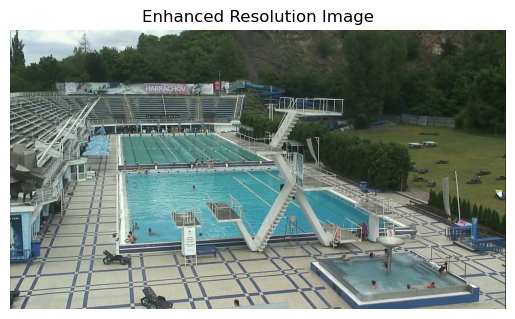

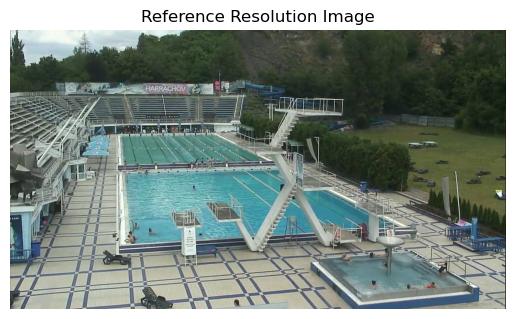

Result saved as enhanced_resolution.png
Reference image saved as ref_img.png


In [26]:
# Define the image paths
image_paths = [r'F:\plovarna\stream_videos\webcam_stream_20240701130000_{}.png'.format(i) for i in range(681, 685)]
print(image_paths)

# Load the images
images = [cv2.imread(image_path) for image_path in image_paths]

# Check if images are loaded successfully
for idx, img in enumerate(images):
    if img is None:
        print(f"Error: Could not load image {image_paths[idx]}")
        exit(1)

# Use the first image as the reference
reference_image = images[0]

# Initialize the aligned images list
aligned_images = []

# Align images to the reference image
for img in images:
    # Use ORB detector to find keypoints and descriptors
    orb = cv2.ORB_create()
    keypoints1, descriptors1 = orb.detectAndCompute(reference_image, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img, None)

    # Match descriptors using BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)

    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)
    for j, match in enumerate(matches):
        points1[j, :] = keypoints1[match.queryIdx].pt
        points2[j, :] = keypoints2[match.trainIdx].pt

    # Find homography matrix
    h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

    if h is not None:
        # Warp image to the reference image
        height, width = reference_image.shape[:2]
        aligned_img = cv2.warpPerspective(img, h, (width, height))
        aligned_images.append(aligned_img)

print(f"{len(aligned_images)} images aligned successfully.")

# Average the aligned images
average_image = np.zeros_like(aligned_images[0], dtype=np.float32)
for img in aligned_images:
    average_image += img.astype(np.float32)

average_image /= len(aligned_images)
average_image = np.clip(average_image, 0, 255).astype(np.uint8)
#average_image = 255-average_image
# Display the result
plt.imshow(cv2.cvtColor(average_image, cv2.COLOR_BGR2RGB))
plt.title('Enhanced Resolution Image')
plt.axis('off')
plt.show()

plt.imshow(cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB))
plt.title('Reference Resolution Image')
plt.axis('off')
plt.show()

# Save the result as a PNG file
result_path = 'enhanced_resolution.png'
cv2.imwrite(result_path, average_image)
print(f"Result saved as {result_path}")

# Save the reference image as a PNG file
reference_result_path = 'ref_img.png'
cv2.imwrite(reference_result_path, reference_image)
print(f"Reference image saved as {reference_result_path}")

14 images aligned successfully.


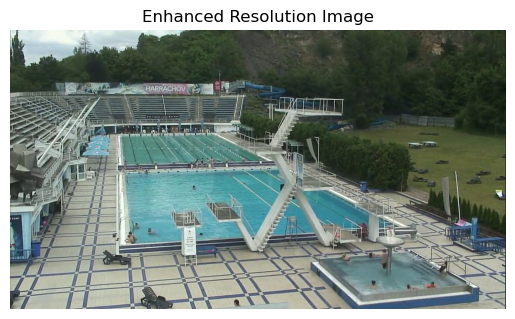

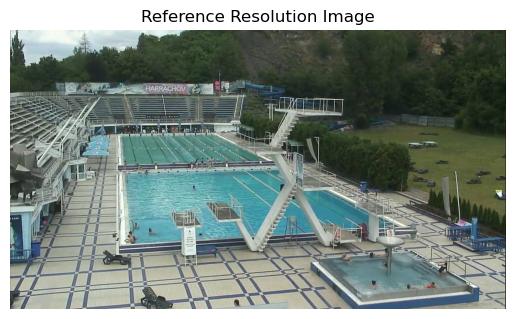

Result saved as enhanced_resolution.png
Reference image saved as ref_img.png


In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the image paths
image_paths = [r'F:\plovarna\stream_videos\webcam_stream_20240701130000_{}.png'.format(i) for i in range(681, 695)]

# Load the images
images = [cv2.imread(image_path) for image_path in image_paths]

# Check if images are loaded successfully
for idx, img in enumerate(images):
    if img is None:
        print(f"Error: Could not load image {image_paths[idx]}")
        exit(1)

# Use the first image as the reference
reference_image = images[0]

# Initialize the aligned images list
aligned_images = []

# Align images to the reference image
for img in images:
    # Use ORB detector to find keypoints and descriptors
    orb = cv2.ORB_create()
    keypoints1, descriptors1 = orb.detectAndCompute(reference_image, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img, None)

    # Match descriptors using BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)

    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Filter out the best matches (you can adjust the threshold)
    num_good_matches = int(len(matches) * 0.15)
    good_matches = matches[:num_good_matches]

    # Extract location of good matches
    points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
    points2 = np.zeros((len(good_matches), 2), dtype=np.float32)
    for j, match in enumerate(good_matches):
        points1[j, :] = keypoints1[match.queryIdx].pt
        points2[j, :] = keypoints2[match.trainIdx].pt

    # Find homography matrix
    h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

    if h is not None:
        # Warp image to the reference image
        height, width = reference_image.shape[:2]
        aligned_img = cv2.warpPerspective(img, h, (width, height))
        aligned_images.append(aligned_img)

print(f"{len(aligned_images)} images aligned successfully.")

# # Average the aligned images
# average_image = np.zeros_like(aligned_images[0], dtype=np.float32)
# for img in aligned_images:
#     average_image += img.astype(np.float32)

# average_image /= len(aligned_images)
# average_image = np.clip(average_image, 0, 255).astype(np.uint8)

def combine_frames_median(frames):
    # Convert list of frames to a numpy array
    stack = np.stack(frames, axis=-1)
    # Compute the median along the stack axis
    median_frame = np.median(stack, axis=-1).astype(np.uint8)
    #median_frame = np.max(stack, axis=-1).astype(np.uint8)
    return median_frame

average_image = combine_frames_median(aligned_images)

# Display the result
plt.imshow(cv2.cvtColor(average_image, cv2.COLOR_BGR2RGB))
plt.title('Enhanced Resolution Image')
plt.axis('off')
plt.show()

plt.imshow(cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB))
plt.title('Reference Resolution Image')
plt.axis('off')
plt.show()

# Save the result as a PNG file
result_path = 'enhanced_resolution.png'
cv2.imwrite(result_path, average_image)
print(f"Result saved as {result_path}")

# Save the reference image as a PNG file
reference_result_path = 'ref_img.png'
cv2.imwrite(reference_result_path, reference_image)
print(f"Reference image saved as {reference_result_path}")


In [ ]:

# Path to the downloaded video file
video_path = 'webcam_stream_1.mp4'

# Open the video file
cap = cv2.VideoCapture(video_path)

# Check if the video was opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
else:
    # Initialize frame count
    frame_count = 0
    target_frame = np.arange(0,800,100)  # We want to extract the 4th frame
    target_frame = [300,310,550]
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(total_frames)

    # Read frames in a loop
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Error: Could not read frame.")
            break

        frame_count += 1
        #print(frame_count)

        # Check if the current frame is the target frame
        if frame_count in target_frame:
            # Convert the frame to RGB (OpenCV uses BGR by default)
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Display the frame
            plt.figure()
            plt.imshow(frame_rgb)
            plt.title(f'Extracted Frame {frame_count}')
            plt.axis('off')
            plt.show()

            # Save the frame as an image file
            cv2.imwrite(f'extracted_frame_{target_frame}.jpg', frame)
        else:
            continue

    # Release the video capture object
    cap.release()


In [ ]:
plt.figure(figsize=(15,10))
plt.imshow(frame_rgb)

In [ ]:
cv2.imwrite(f'extracted_frame.tiff', frame_rgb)

In [ ]:
cv2.imwrite('extracted_frame.tiff', cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR))

## Yolo detect people

In [5]:
from ultralytics import YOLO

In [10]:
# Load a model
model = YOLO("yolov9e.pt")  # pretrained YOLOv8n model

# Run batched inference on a list of images
results = model(["webcam_stream_20240629165237_85_rs.png", "enhanced_resolution.png"])  # return a list of Results objects

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    result.save(filename="webcam_stream_20240629165237_85_rs_yolo.jpg")  # save to disk


0: 640x640 1 bench, 1 chair, 3081.6ms
1: 640x640 1 bench, 1 chair, 3081.6ms
Speed: 7.8ms preprocess, 3081.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
import cv2
import torch
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np

# Path to the uploaded TIFF file
tiff_path = 'extracted_frame.tiff'

# Load the TIFF image using OpenCV
image = cv2.imread(tiff_path, cv2.IMREAD_UNCHANGED)
if image is None:
    print("Error: Could not load image.")
else:
    # Convert the image to RGB (OpenCV loads images in BGR format)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Define the transformation for the input image
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
    ])

    # Transform the image
    input_image = transform(image_rgb)
    input_image = input_image.unsqueeze(0)  # Add batch dimension

    # Load a pre-trained Faster R-CNN model
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    model.eval()

    # Perform object detection
    with torch.no_grad():
        detections = model(input_image)

    # Extract the detections
    detections = detections[0]
    threshold = 0.8  # Confidence threshold
    labels = detections['labels'].numpy()
    scores = detections['scores'].numpy()
    boxes = detections['boxes'].numpy()

    # Filter detections for people (label 1 corresponds to 'person' in COCO dataset)
    person_boxes = boxes[(labels == 1) & (scores >= threshold)]

    # Draw bounding boxes around detected people
    for box in person_boxes:
        x1, y1, x2, y2 = box
        cv2.rectangle(image_rgb, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

    # Display the result
    plt.imshow(image_rgb)
    plt.title('Detected People in Swimming Pool')
    plt.axis('off')
    plt.show()

    # Save the result as a PNG file
    result_path = '/mnt/data/detected_people.png'
    cv2.imwrite(result_path, cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR))
    print(f"Result saved as {result_path}")


In [ ]:
import torch
x = torch.rand(5, 3)
print(x)

In [ ]:
# Load the image
image_path = r'c:\Users\martin\extracted_frame.tiff'  # Replace with your image path
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(image_rgb)

In [ ]:
# Convert to HSV color space
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

plt.figure()
plt.imshow(image_hsv)

In [ ]:

# Define the HSV range for the color of the pool
lower_blue = np.array([20, 50, 50])  # Adjust these values as needed
upper_blue = np.array([130, 255, 255])

# Create a mask using the color range
mask = cv2.inRange(image_hsv, lower_blue, upper_blue)

# Apply the mask to the original image
result = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)

# Convert the result to grayscale
gray = cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)

# Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(gray, (13, 13), 0)

# Perform Canny edge detection
edges = cv2.Canny(blurred, 50, 190)

# Find contours in the edge-detected image
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contour_image = image_rgb.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)


longest_contour = max(contours, key=lambda x: cv2.arcLength(x, False))
lrg_cnt_image = image_rgb.copy()
cv2.drawContours(lrg_cnt_image,longest_contour,-1,(0,255,0),2)





plt.figure()
plt.imshow(blurred)

plt.figure()
plt.imshow(edges)

plt.figure()
plt.imshow(contour_image)

plt.figure()
plt.imshow(lrg_cnt_image)

In [ ]:
largest_contour = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(largest_contour)
print(x,y,w,h)
bounding_box_image = image_rgb.copy()

In [ ]:
cv2.rectangle(bounding_box_image,(x,y),((x+w),(y+h)),(255,0,0))
# Display the image with the bounding box
plt.imshow(bounding_box_image)
plt.title('Bounding Box')
plt.axis('off')
plt.show()

In [ ]:


# Create a bounding box around the largest contour
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Draw the bounding box on the image
    bounding_box_image = image_rgb.copy()
    cv2.rectangle(bounding_box_image, (x, y), (x+w), (y+h), (255, 0, 0), 2)
    
    # Display the image with the bounding box
    plt.imshow(bounding_box_image)
    plt.title('Bounding Box')
    plt.axis('off')
    plt.show()


## process labels cvat

In [2]:
import os
import shutil

In [3]:
labels_txt = os.listdir(r'f:\plovarna\lables_2\liode_2_2\obj_train_data')
src_img_dir = r'f:\plovarna\stream_videos'
dst_img_dir = r'f:\plovarna\lables_2\liode_2_2\images'

for label in labels_txt:
    img_name = label.split('.')[0]+'.png'
    src_img = os.path.join(src_img_dir,img_name)
    dst_img = os.path.join(dst_img_dir,img_name)
    shutil.copyfile(src_img,dst_img)

In [136]:
img_name = labels_txt[0].split('.')[0]+'.png'

In [137]:


#shutil.copyfile(src, dst)

In [138]:
src_dir = r'f:\plovarna\stream_videos'
dst_dir = r'f:\plovarna\labels\labels_images'

src = os.path.join(src_dir,img_name)
dst = os.path.join(dst_dir,img_name)

In [139]:
shutil.copyfile(src,dst)

'f:\\plovarna\\labels\\labels_images\\webcam_stream_20240701180000_793.png'

## Detect change of direction in frames

In [4]:
import os
import glob

In [7]:
src_img_dir = r'f:\plovarna\stream_videos\20240701080000'
# Find all .png files in the directory
png_files = glob.glob(os.path.join(src_img_dir, '*.png'))

# Sort the files by name
png_files.sort(key=os.path.getmtime)

# Print sorted list of .png files
for file in png_files:
    print(file)

f:\plovarna\stream_videos\20240701080000\webcam_stream_20240701080000_1.png
f:\plovarna\stream_videos\20240701080000\webcam_stream_20240701080000_2.png
f:\plovarna\stream_videos\20240701080000\webcam_stream_20240701080000_3.png
f:\plovarna\stream_videos\20240701080000\webcam_stream_20240701080000_4.png
f:\plovarna\stream_videos\20240701080000\webcam_stream_20240701080000_5.png
f:\plovarna\stream_videos\20240701080000\webcam_stream_20240701080000_6.png
f:\plovarna\stream_videos\20240701080000\webcam_stream_20240701080000_7.png
f:\plovarna\stream_videos\20240701080000\webcam_stream_20240701080000_8.png
f:\plovarna\stream_videos\20240701080000\webcam_stream_20240701080000_9.png
f:\plovarna\stream_videos\20240701080000\webcam_stream_20240701080000_10.png
f:\plovarna\stream_videos\20240701080000\webcam_stream_20240701080000_11.png
f:\plovarna\stream_videos\20240701080000\webcam_stream_20240701080000_12.png
f:\plovarna\stream_videos\20240701080000\webcam_stream_20240701080000_13.png
f:\plova

In [8]:
import cv2
import numpy as np
import glob
import os

In [12]:
def detect_motion_direction(frames):
    # Initialize ORB detector
    orb = cv2.ORB_create()

    # Initialize BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    prev_kp = None
    prev_des = None
    prev_gray = None
    motions = []

    for i, frame in enumerate(frames):
        # Convert frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Detect ORB features and descriptors
        kp, des = orb.detectAndCompute(gray, None)
        
        if prev_kp is not None and prev_des is not None:
            # Match features between frames
            matches = bf.match(prev_des, des)
            
            # Extract location of matched points
            src_pts = np.float32([prev_kp[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
            
            # Calculate optical flow
            flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            
            # Calculate motion (translation)
            motion = np.mean(flow, axis=0)
            motions.append(motion)
        
        # Update previous frame data
        prev_kp, prev_des = kp, des
        prev_gray = gray

    # Analyze motions to detect stop and direction
    stop_frame = None
    direction = None
    for i, motion in enumerate(motions):
        if np.linalg.norm(motion) < 1e-2:  # Threshold for stop detection
            stop_frame = i
            break
        direction = "right" if motion[0] > 0 else "left"
    
    return stop_frame, direction

In [13]:
# Load PNG frames
def load_frames_from_directory(directory_path):
    # Find all .png files in the directory and sort them by name
    png_files = sorted(glob.glob(os.path.join(directory_path, '*.png')))
    
    frames = []
    for file in png_files:
        frame = cv2.imread(file)
        frames.append(frame)
    
    return frames

In [14]:
# Example usage
directory_path = r'f:\plovarna\stream_videos\20240701080000'
frames = load_frames_from_directory(directory_path)

In [15]:
# Detect motion and direction
stop_frame, direction = detect_motion_direction(frames)

if stop_frame is not None:
    print(f"Camera stopped rotating at frame {stop_frame}.")
    print(f"Direction before stopping: {direction}")
else:
    print("Camera did not stop rotating in the given frames.")


KeyboardInterrupt: 

### trivial motion detection

In [39]:
def median_filter_1d(data, window_size):
    """
    Apply a centered 1D median filter to the input data.

    :param data: 1D array of data to be filtered
    :param window_size: Size of the median filter window (must be an odd number)
    :return: Filtered data
    """
    if window_size % 2 == 0:
        raise ValueError("Window size must be an odd number")
    
    half_window = window_size // 2
    data_length = len(data)
    filtered_data = np.zeros(data_length)

    for i in range(data_length):
        start_index = max(0, i - half_window)
        end_index = min(data_length, i + half_window + 1)
        filtered_data[i] = np.median(data[start_index:end_index])

    return filtered_data

In [17]:
frameA = cv2.imread(r'f:\plovarna\stream_videos\20240701080000\webcam_stream_20240701080000_355.png')
frameB = cv2.imread(r'f:\plovarna\stream_videos\20240701080000\webcam_stream_20240701080000_356.png')

frameC = cv2.imread(r'f:\plovarna\stream_videos\20240701080000\webcam_stream_20240701080000_380.png')
frameD = cv2.imread(r'f:\plovarna\stream_videos\20240701080000\webcam_stream_20240701080000_381.png')

In [20]:
np.mean(frameA-frameB)

9.570562789351852

In [21]:
np.mean(frameC-frameD)

115.09713975694444

In [26]:
np.mean(frameA[:,0,:]-frameB[:,0,:])

7.6722222222222225

In [105]:
np.min([4,5])

4

In [106]:
src_img_dir = r'f:\plovarna\stream_videos\20240701100000'
# Find all .png files in the directory
png_files = glob.glob(os.path.join(src_img_dir, '*.png'))
# Sort the files by name
png_files.sort(key=os.path.getmtime)
# Print sorted list of .png files
dif_lst = [-999]
for i,file in enumerate(png_files):
    if i > 0:
        frameA = cv2.imread(png_files[i-1])
        frameB = cv2.imread(png_files[i])
        dif_mean1 = np.mean(frameA[:,0,:]-frameB[:,0,:])
        dif_mean2 = np.mean(frameA[:,-1,:]-frameB[:,-1,:])
        dif_mean = np.min([dif_mean1,dif_mean2])
        #dif_mean = np.mean(frameB-frameA)
        dif_lst.append(dif_mean)
dif_lst[0]=dif_lst[1]
dif_lst = np.array(dif_lst)

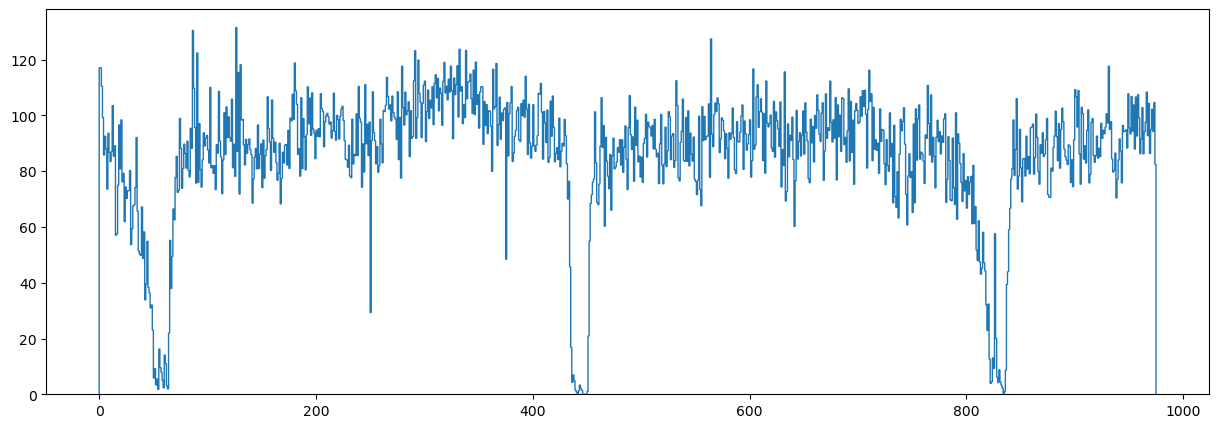

In [107]:
plt.figure(figsize=(15,5))
plt.stairs(dif_lst)
plt.show()

In [108]:
np.where(dif_lst<80)

(array([  7,  15,  16,  17,  21,  22,  23,  24,  25,  26,  27,  29,  30,
         31,  32,  33,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
         45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
         58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
         72,  73,  76,  83,  89,  91,  94, 105, 107, 113, 125, 129, 141,
        142, 150, 152, 164, 165, 167, 168, 185, 231, 232, 242, 244, 250,
        257, 278, 362, 375, 432, 433, 434, 435, 436, 437, 438, 439, 440,
        441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453,
        454, 455, 456, 459, 460, 461, 466, 469, 470, 472, 483, 487, 493,
        499, 501, 516, 520, 534, 535, 549, 550, 551, 552, 554, 555, 563,
        580, 587, 601, 614, 629, 633, 634, 641, 642, 654, 655, 668, 680,
        696, 719, 725, 728, 732, 734, 735, 736, 737, 744, 745, 746, 748,
        749, 750, 752, 761, 771, 781, 782, 785, 786, 788, 789, 791, 795,
        796, 798, 799, 800, 801, 802, 803, 804, 805

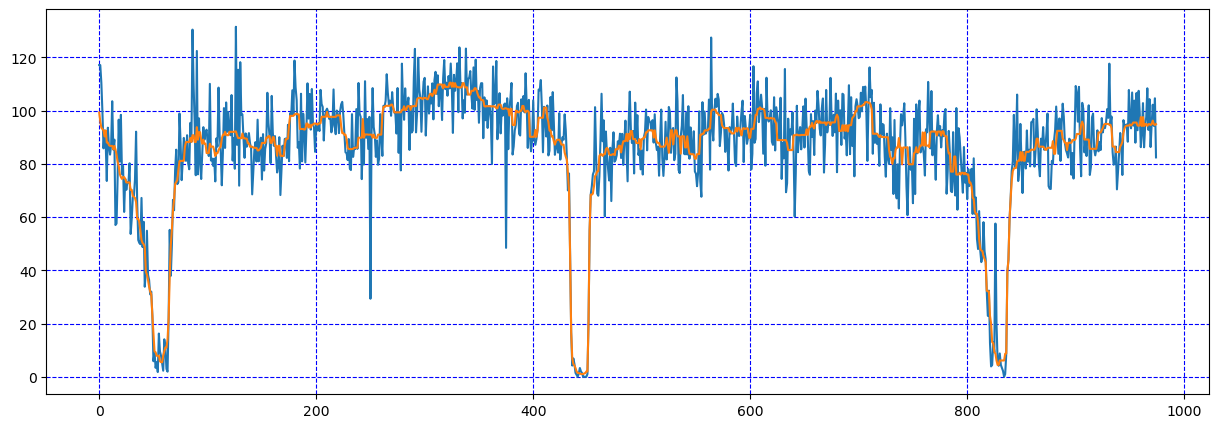

In [117]:
dif_lst_flt = median_filter_1d(dif_lst,13)
#dif_lst_flt2 = median_filter_1d(dif_lst_flt,15)
#dif_lst_flt = median_filter_1d(dif_lst_flt,3)
plt.figure(figsize=(15,5))
plt.plot(dif_lst)
plt.plot(dif_lst_flt)
#plt.plot(np.diff(dif_lst_flt))
#plt.grid()
plt.grid(which='both', color='b', linestyle='--',axis='both')
plt.show()

In [119]:
from scipy.signal import find_peaks

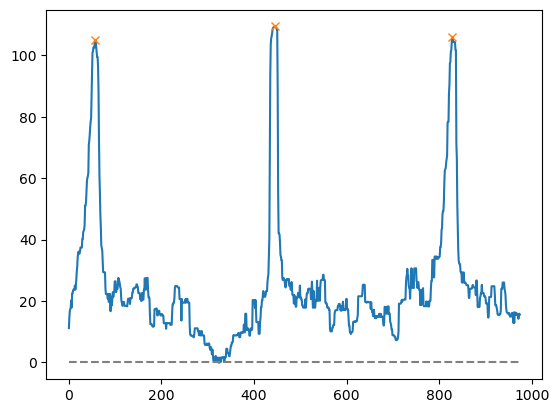

In [166]:
dif_lst_flt_inv = dif_lst_flt*-1+max(dif_lst_flt)
peaks, _ = find_peaks(dif_lst_flt_inv,prominence=30)
plt.plot(dif_lst_flt_inv)
plt.plot(peaks, dif_lst_flt_inv[peaks], "x")
plt.plot(np.zeros_like(dif_lst_flt_inv), "--", color="gray")
plt.show()

Peaks and their bounds:
Peak at index 57 with start at index 22 and end at index 84
Peak at index 445 with start at index 422 and end at index 463
Peak at index 828 with start at index 798 and end at index 849


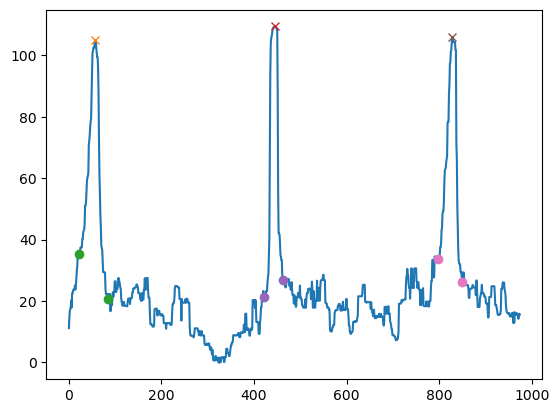

In [168]:
def find_peaks_with_bounds(data):
    # Find peaks
    peaks, _ = find_peaks(data,prominence=30)
    
    # Find start and end points of each peak at the bottom
    peak_bounds = []
    for peak in peaks:
        # Find the start point
        start = peak
        while start > 0 and data[start] >= data[start - 1]:
            start -= 1
        
        # Find the end point
        end = peak
        while end < len(data) - 1 and data[end] >= data[end + 1]:
            end += 1
        
        peak_bounds.append((start, peak, end))
    
    return peak_bounds


# Find peaks and their bounds
peak_bounds = find_peaks_with_bounds(dif_lst_flt_inv)

# Print results
print("Peaks and their bounds:")
for start, peak, end in peak_bounds:
    print(f"Peak at index {peak} with start at index {start} and end at index {end}")

# Plotting
plt.plot(dif_lst_flt_inv)
for start, peak, end in peak_bounds:
    plt.plot(peak, dif_lst_flt_inv[peak], "x")
    plt.plot([start, end], [dif_lst_flt_inv[start], dif_lst_flt_inv[end]], "o")
plt.show()


In [96]:
np.where(dif_lst_flt<40)

(array([352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364,
        365, 366, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748,
        749, 750, 751, 752, 753], dtype=int64),)

In [ ]:
# Load PNG frames
def load_frames_from_directory(directory_path):
    # Find all .png files in the directory and sort them by name
    png_files = sorted(glob.glob(os.path.join(directory_path, '*.png')))
    
    frames = []
    for file in png_files:
        frame = cv2.imread(file)
        frames.append(frame)
    
    return frames